In [ ]:
!pip install pandas openpyxl matplotlib scikit-learn joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 388.0 kB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
df = pd.read_excel("./data/Online Retail.xlsx") 

In [3]:
# df =df.head()

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
columns_to_check = ['Quantity', 'UnitPrice']

max_values = df[columns_to_check].max()
min_values = df[columns_to_check].min()

print("Maximum values:")
print(max_values)

print("\nMinimum values:")
print(min_values)

Maximum values:
Quantity     80995.0
UnitPrice    38970.0
dtype: float64

Minimum values:
Quantity    -80995.00
UnitPrice   -11062.06
dtype: float64


In [8]:
df= df[(df['Quantity'] >= 0) & (df['UnitPrice'] >= 0)]

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
invalid_dates = df[pd.isna(df['InvoiceDate'])]
print("\nInvalid dates in 'InvoiceDate' column:")
print(invalid_dates)


Invalid dates in 'InvoiceDate' column:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [11]:
df['hour'] = df['InvoiceDate'].dt.hour

df['weekday'] = df['InvoiceDate'].dt.weekday

df['month'] = df['InvoiceDate'].dt.month

df['week'] = df['InvoiceDate'].dt.isocalendar().week

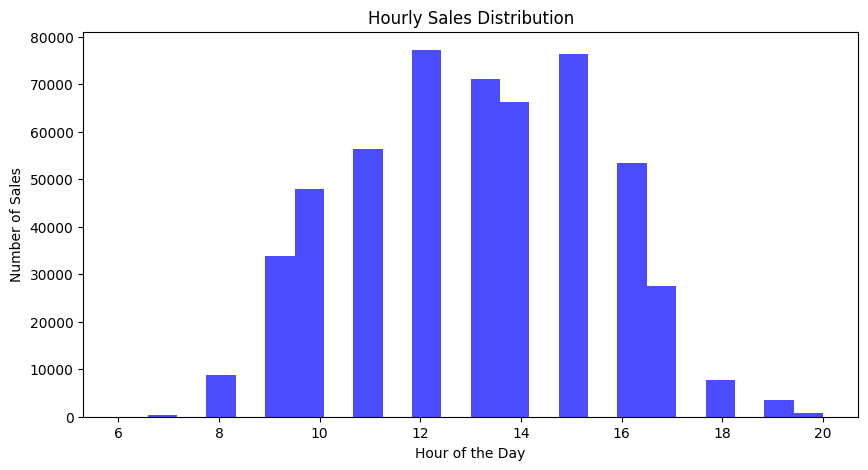

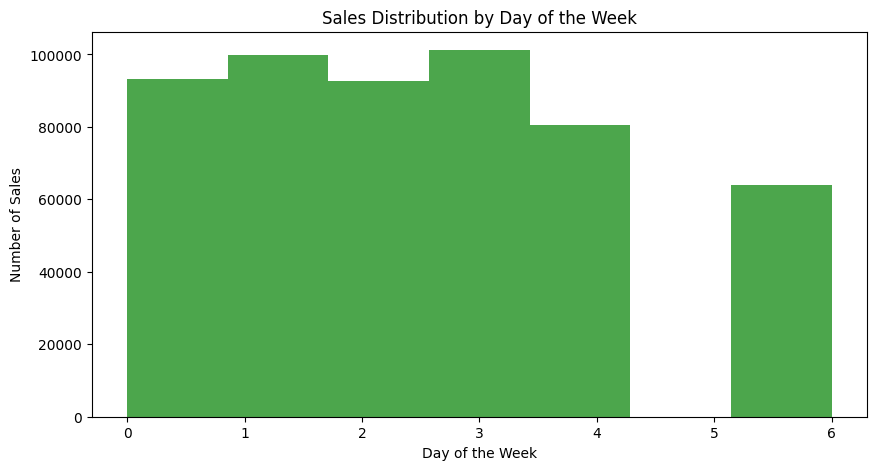

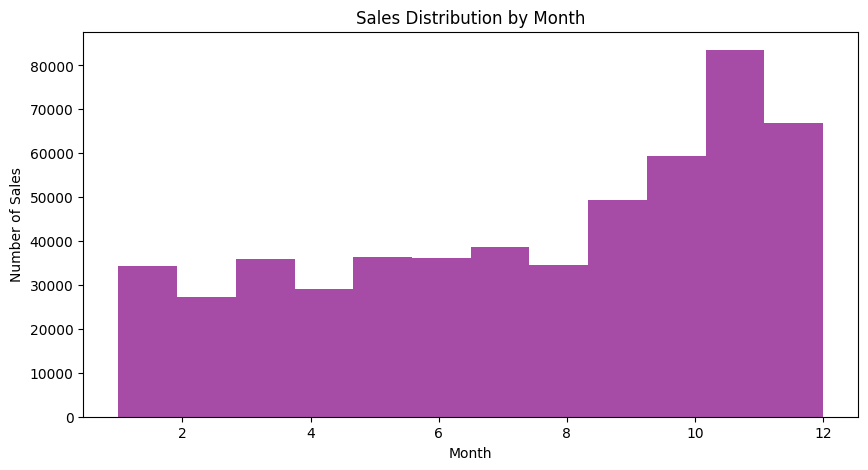

In [12]:
# Plotting Hourly Sales
plt.figure(figsize=(10, 5))
plt.hist(df['hour'], bins=24, alpha=0.7, color='blue')
plt.title('Hourly Sales Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Sales')
plt.show()

# Plotting Weekly Sales
plt.figure(figsize=(10, 5))
plt.hist(df['weekday'], bins=7, alpha=0.7, color='green')
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sales')
plt.show()

# Plotting Monthly Sales
plt.figure(figsize=(10, 5))
plt.hist(df['month'], bins=12, alpha=0.7, color='purple')
plt.title('Sales Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.show()


In [13]:
df['total_sales'] = df['UnitPrice'] * df['Quantity']


In [14]:
def calculate_peak_periods(data, group_by_column, top_n_percent=20):
    period_sales = data.groupby(group_by_column)['total_sales'].sum().reset_index()
    period_sales_sorted = period_sales.sort_values(by='total_sales', ascending=False)
    num_peak_periods = int((top_n_percent / 100) * len(period_sales_sorted))
    peak_periods = period_sales_sorted.head(num_peak_periods)[group_by_column].tolist()
    return peak_periods

In [15]:

peak_months = calculate_peak_periods(df, 'month')
peak_weeks = calculate_peak_periods(df, 'week')
peak_weekdays = calculate_peak_periods(df, 'weekday')
peak_hours = calculate_peak_periods(df, 'hour')

In [16]:
def assign_peak_level_combined(row):
    peak_count = sum([
        row['month'] in peak_months,
        row['week'] in peak_weeks,
        row['weekday'] in peak_weekdays,
        row['hour'] in peak_hours
    ])
    return ['Very Low', 'Low', 'Medium', 'High', 'Very High'][peak_count]


In [17]:
df['peak_period_level'] = df.apply(assign_peak_level_combined, axis=1)

In [ ]:
# df[df['peak_period_level'] = 'Very Low'].sum()

SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (4053592481.py, line 1)

In [ ]:
product_demand = df.groupby('StockCode')['Quantity'].sum().reset_index()
product_demand.rename(columns={'Quantity': 'total_quantity'}, inplace=True)

In [ ]:
high_demand_threshold = np.percentile(product_demand['total_quantity'], 80)  # Top 20% demand
low_demand_threshold = np.percentile(product_demand['total_quantity'], 20)  # Bottom 20% demand

In [ ]:
def assign_demand_level(total_quantity):
    if total_quantity > high_demand_threshold:
        return 'High'
    elif total_quantity < low_demand_threshold:
        return 'Low'
    else:
        return 'Medium'

In [ ]:
product_demand['overall_demand_level'] = product_demand['total_quantity'].apply(assign_demand_level)

In [ ]:
df = df.merge(product_demand[['StockCode', 'overall_demand_level']], on='StockCode')

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,weekday,month,week,total_sales,peak_period_level,overall_demand_level
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,12,48,15.30,Very Low,High
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,Medium
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,12,48,22.00,Very Low,High
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97916,544795,22815,CARD PSYCHEDELIC APPLES,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High
97917,544795,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High
97918,544795,22035,VINTAGE CARAVAN GREETING CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,Medium
97919,544795,22024,RAINY LADIES BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
reference_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'UnitPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,36,1,1.04
1,12347.0,27,60,162.76
2,12348.0,29,23,91.61
3,12350.0,20,17,65.30
4,12352.0,7,15,68.35


In [ ]:
rfm['RecencySegment'] = pd.qcut(rfm['Recency'], 4, labels=['High', 'Medium', 'Low', 'Very Low'])
rfm['FrequencySegment'] = pd.qcut(rfm['Frequency'], 4, labels=['Very Low', 'Low', 'Medium', 'High'])
rfm['MonetarySegment'] = pd.qcut(rfm['Monetary'], 4, labels=['Very Low', 'Low', 'Medium', 'High'])

In [ ]:
df = df.merge(rfm[['CustomerID', 'RecencySegment','FrequencySegment','MonetarySegment']], on='CustomerID', how='left')

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,weekday,month,week,total_sales,peak_period_level,overall_demand_level,RecencySegment,FrequencySegment,MonetarySegment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,12,48,15.30,Very Low,High,Very Low,High,High
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,Medium,Very Low,High,High
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,12,48,22.00,Very Low,High,Very Low,High,High
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97916,544795,22815,CARD PSYCHEDELIC APPLES,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High
97917,544795,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High
97918,544795,22035,VINTAGE CARAVAN GREETING CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,Medium,High,High,High
97919,544795,22024,RAINY LADIES BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High


In [ ]:
unique_countries = df['Country'].nunique()

print(f"Number of unique country: {unique_countries}")

Number of unique country: 29


In [ ]:
all_countries_stats = df.groupby('Country').agg(
    total_sales=('total_sales', 'sum'),
    avg_unit_price=('UnitPrice', 'mean')
).reset_index()

In [ ]:
all_countries_stats

,Country,total_sales,avg_unit_price
0,Australia,24333.43,2.945714
1,Austria,795.56,6.045172
2,Bahrain,205.74,3.810000
3,Belgium,4851.33,3.365914
4,Channel Islands,2823.82,6.497193
5,Cyprus,6472.56,7.339765
6,Denmark,1680.72,3.922500
7,EIRE,44186.19,4.295587
8,Finland,1781.82,5.223214
9,France,33870.52,3.326235


In [ ]:
countries_excluding_uk_stats = all_countries_stats[all_countries_stats['Country'] != 'United Kingdom']

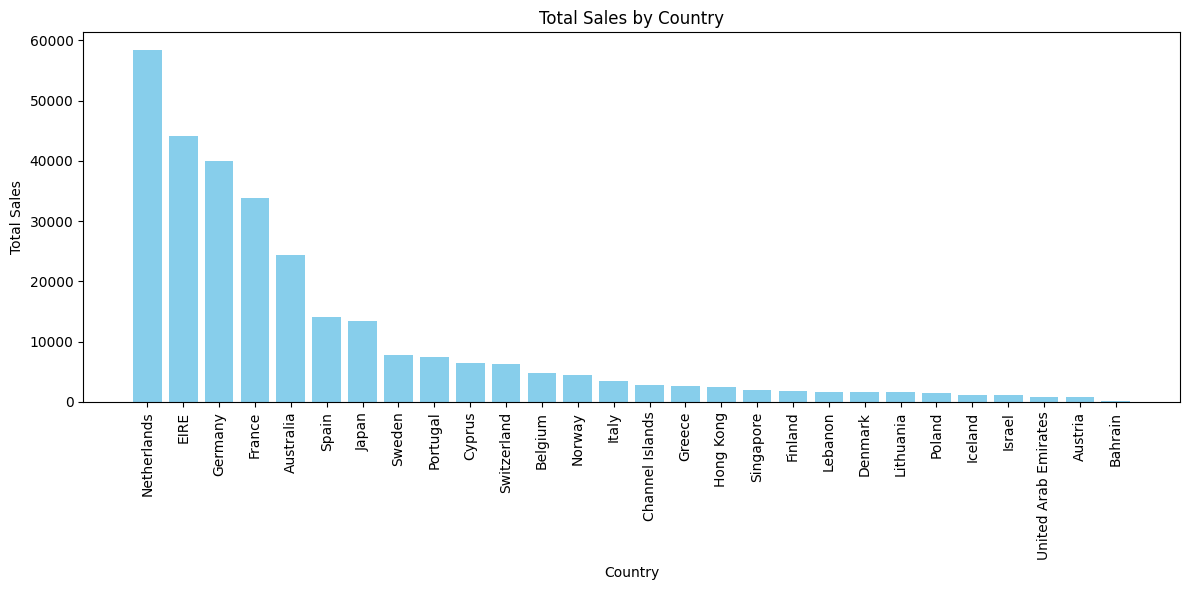

In [ ]:
plt.figure(figsize=(12, 6))
country_stats_sorted = countries_excluding_uk_stats.sort_values('total_sales', ascending=False)
plt.bar(country_stats_sorted['Country'], country_stats_sorted['total_sales'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [ ]:
high_demand_threshold_excluding_uk = np.percentile(countries_excluding_uk_stats['total_sales'], 80)  # Top 20% sales
low_demand_threshold_excluding_uk = np.percentile(countries_excluding_uk_stats['total_sales'], 20)  # Bottom 20% sales

In [ ]:
high_demand_threshold_including_uk = np.percentile(all_countries_stats['total_sales'], 80)  # Top 20% sales
low_demand_threshold_including_uk = np.percentile(all_countries_stats['total_sales'], 20)  # Bottom 20% sales

In [ ]:
low_demand_threshold_excluding_uk

1543.682

In [ ]:
low_demand_threshold_including_uk

1582.808

In [ ]:
high_demand_threshold_excluding_uk

13820.944

In [ ]:
low_demand_threshold_excluding_uk

1543.682

In [ ]:
def demand_level(country, total_sales):
    high_threshold, low_threshold = (
        (high_demand_threshold_including_uk, low_demand_threshold_including_uk)
        if country == 'United Kingdom'
        else (high_demand_threshold_excluding_uk, low_demand_threshold_excluding_uk)
    )
    return 'High' if total_sales > high_threshold else 'Low' if total_sales < low_threshold else 'Medium'


In [ ]:
all_countries_stats['country_purchasing_power'] = all_countries_stats.apply(
    lambda x: demand_level(x['Country'], x['total_sales']), axis=1
)

In [ ]:
df = df.merge(all_countries_stats[['Country', 'country_purchasing_power']], on='Country', how='left')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,weekday,month,week,total_sales,peak_period_level,overall_demand_level,RecencySegment,FrequencySegment,MonetarySegment,country_purchasing_power
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,12,48,15.30,Very Low,High,Very Low,High,High,High
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,Medium,Very Low,High,High,High
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,12,48,22.00,Very Low,High,Very Low,High,High,High
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High,High
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High,High


In [ ]:
import pandas as pd

grouped_data = df.groupby(['StockCode', 'Country'])

grouped_sales = grouped_data['Quantity'].sum() * grouped_data['UnitPrice'].sum()

order_intensity = grouped_sales.reset_index(name='total_sales')

print(order_intensity)


         StockCode         Country  total_sales
0            10002            EIRE        10.20
1            10002          France      1499.40
2            10002         Germany         0.85
3            10002           Japan         0.85
4            10002           Spain        20.40
...            ...             ...          ...
7605  gift_0001_20  United Kingdom       151.08
7606  gift_0001_30  United Kingdom       226.59
7607  gift_0001_40  United Kingdom        34.04
7608  gift_0001_50  United Kingdom        42.55
7609             m  United Kingdom         2.55

[7610 rows x 3 columns]


In [ ]:
grouped_sales = df.groupby(['StockCode', 'Country'])['total_sales'].sum().reset_index()

In [ ]:
def calculate_thresholds(group):
    # Compute thresholds for the product across countries
    thresholds = {
        'very_low_threshold': group['total_sales'].quantile(0.10),
        'low_threshold': group['total_sales'].quantile(0.25),
        'medium_threshold': group['total_sales'].quantile(0.50),
        'high_threshold': group['total_sales'].quantile(0.75),
        'very_high_threshold': group['total_sales'].quantile(0.90),
    }
    return pd.Series(thresholds)

In [ ]:
thresholds = grouped_sales.groupby('StockCode').apply(calculate_thresholds).reset_index()

/tmp/ipykernel_31502/2870278470.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  thresholds = grouped_sales.groupby('StockCode').apply(calculate_thresholds).reset_index()


In [ ]:
grouped_sales = grouped_sales.merge(thresholds, on='StockCode')

In [ ]:
grouped_sales

,StockCode,Country,total_sales,very_low_threshold,low_threshold,medium_threshold,high_threshold,very_high_threshold
0,10002,EIRE,10.20,0.85,5.525,10.20,117.30,246.296
1,10002,France,214.20,0.85,5.525,10.20,117.30,246.296
2,10002,Germany,0.85,0.85,5.525,10.20,117.30,246.296
3,10002,Japan,0.85,0.85,5.525,10.20,117.30,246.296
4,10002,Spain,20.40,0.85,5.525,10.20,117.30,246.296
...,...,...,...,...,...,...,...,...
7605,gift_0001_20,United Kingdom,50.36,50.36,50.360,50.36,50.36,50.360
7606,gift_0001_30,United Kingdom,75.53,75.53,75.530,75.53,75.53,75.530
7607,gift_0001_40,United Kingdom,34.04,34.04,34.040,34.04,34.04,34.040
7608,gift_0001_50,United Kingdom,42.55,42.55,42.550,42.55,42.55,42.550


In [ ]:
def assign_level(row):
    if row['total_sales'] <= row['very_low_threshold']:
        return 'Very Low'
    elif row['total_sales'] <= row['low_threshold']:
        return 'Low'
    elif row['total_sales'] <= row['medium_threshold']:
        return 'Medium'
    elif row['total_sales'] <= row['high_threshold']:
        return 'High'
    else:
        return 'Very High'

In [ ]:
grouped_sales['sales_level_by_country'] = grouped_sales.apply(assign_level, axis=1)

In [ ]:
grouped_sales

,StockCode,Country,total_sales,very_low_threshold,low_threshold,medium_threshold,high_threshold,very_high_threshold,sales_level_by_country
0,10002,EIRE,10.20,0.85,5.525,10.20,117.30,246.296,Medium
1,10002,France,214.20,0.85,5.525,10.20,117.30,246.296,Very High
2,10002,Germany,0.85,0.85,5.525,10.20,117.30,246.296,Very Low
3,10002,Japan,0.85,0.85,5.525,10.20,117.30,246.296,Very Low
4,10002,Spain,20.40,0.85,5.525,10.20,117.30,246.296,High
...,...,...,...,...,...,...,...,...,...
7605,gift_0001_20,United Kingdom,50.36,50.36,50.360,50.36,50.36,50.360,Very Low
7606,gift_0001_30,United Kingdom,75.53,75.53,75.530,75.53,75.53,75.530,Very Low
7607,gift_0001_40,United Kingdom,34.04,34.04,34.040,34.04,34.04,34.040,Very Low
7608,gift_0001_50,United Kingdom,42.55,42.55,42.550,42.55,42.55,42.550,Very Low


In [ ]:
df = df.merge(grouped_sales[['StockCode', 'Country', 'sales_level_by_country']],on=['StockCode','Country'],how='left')

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,weekday,month,week,total_sales,peak_period_level,overall_demand_level,RecencySegment,FrequencySegment,MonetarySegment,country_purchasing_power,sales_level_by_country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,12,48,15.30,Very Low,High,Very Low,High,High,High,Very High
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,Medium,Very Low,High,High,High,Very High
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,12,48,22.00,Very Low,High,Very Low,High,High,High,Very High
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High,High,Very High
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,48,20.34,Very Low,High,Very Low,High,High,High,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97916,544795,22815,CARD PSYCHEDELIC APPLES,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High,High,Very High
97917,544795,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High,High,Very High
97918,544795,22035,VINTAGE CARAVAN GREETING CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,Medium,High,High,High,High,Very High
97919,544795,22024,RAINY LADIES BIRTHDAY CARD,12,2011-02-23 13:21:00,0.42,15858.0,United Kingdom,13,2,2,8,5.04,Very Low,High,High,High,High,High,Very High


In [ ]:
# Specify the columns you are interested in
columns_of_interest = ['peak_period_level', 'overall_demand_level','RecencySegment','FrequencySegment','MonetarySegment','country_purchasing_power','sales_level_by_country']

# Get unique values for specified columns only
unique_values = {col: df[col].unique().tolist() for col in columns_of_interest}

print(unique_values)

{'peak_period_level': ['Very Low', 'Low', 'Medium', 'High'], 'overall_demand_level': ['High', 'Medium', 'Low'], 'RecencySegment': ['Very Low', 'Medium', 'High', 'Low', nan], 'FrequencySegment': ['High', 'Medium', 'Very Low', 'Low', nan], 'MonetarySegment': ['High', 'Medium', 'Very Low', 'Low', nan], 'country_purchasing_power': ['High', 'Medium', 'Low'], 'sales_level_by_country': ['Very High', 'Very Low', 'High', 'Medium', 'Low']}


In [ ]:
def adjust_unit_price(row):
    price_adjustment = 0

    # Adjust based on 'peak_period_level'
    if row['peak_period_level'] == 'High':
        price_adjustment += 0.10  # 10% increase
    elif row['peak_period_level'] == 'Very High':
        price_adjustment += 0.20  # 20% increase
    elif row['peak_period_level'] == 'Low':
        price_adjustment -= 0.05  # 5% decrease
    elif row['peak_period_level'] == 'Very Low':
        price_adjustment -= 0.10  # 10% decrease

    # Adjust based on 'overall_demand_level'
    if row['overall_demand_level'] == 'High':
        price_adjustment += 0.15  # 15% increase
    elif row['overall_demand_level'] == 'Medium':
        price_adjustment += 0.05  # 5% increase
    elif row['overall_demand_level'] == 'Low':
        price_adjustment -= 0.10  # 10% decrease

    # Adjust based on 'RecencySegment'
    if row['RecencySegment'] == 'High':
        price_adjustment += 0.05  # 5% increase
    elif row['RecencySegment'] == 'Medium':
        price_adjustment += 0.03  # 3% increase
    elif row['RecencySegment'] == 'Low' or row['RecencySegment'] == 'Very Low':
        price_adjustment -= 0.05  # 5% decrease

    # Adjust based on 'FrequencySegment'
    if row['FrequencySegment'] == 'High':
        price_adjustment += 0.10  # 10% increase
    elif row['FrequencySegment'] == 'Medium':
        price_adjustment += 0.05  # 5% increase
    elif row['FrequencySegment'] == 'Low' or row['FrequencySegment'] == 'Very Low':
        price_adjustment -= 0.05  # 5% decrease

    # Adjust based on 'MonetarySegment'
    if row['MonetarySegment'] == 'High':
        price_adjustment += 0.10  # 10% increase
    elif row['MonetarySegment'] == 'Medium':
        price_adjustment += 0.05  # 5% increase
    elif row['MonetarySegment'] == 'Low' or row['MonetarySegment'] == 'Very Low':
        price_adjustment -= 0.05  # 5% decrease

    # Adjust based on 'country_purchasing_power'
    if row['country_purchasing_power'] == 'High':
        price_adjustment += 0.08  # 8% increase
    elif row['country_purchasing_power'] == 'Medium':
        price_adjustment += 0.04  # 4% increase
    elif row['country_purchasing_power'] == 'Low':
        price_adjustment -= 0.08  # 8% decrease

    # Adjust based on 'sales_level_by_country'
    if row['sales_level_by_country'] == 'Very High':
        price_adjustment += 0.15  # 15% increase
    elif row['sales_level_by_country'] == 'High':
        price_adjustment += 0.12  # 12% increase
    elif row['sales_level_by_country'] == 'Medium':
        price_adjustment += 0.05  # 5% increase
    elif row['sales_level_by_country'] == 'Low':
        price_adjustment -= 0.10  # 10% decrease
    elif row['sales_level_by_country'] == 'Very Low':
        price_adjustment -= 0.15  # 15% decrease

    # Apply the adjustment to the unit price
    new_unit_price = row['UnitPrice'] * (1 + price_adjustment)

    return new_unit_price


In [ ]:
df['adjusted_unit_price'] = df.apply(adjust_unit_price, axis=1)

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,weekday,...,week,total_sales,peak_period_level,overall_demand_level,RecencySegment,FrequencySegment,MonetarySegment,country_purchasing_power,sales_level_by_country,adjusted_unit_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,...,48,15.30,Very Low,High,Very Low,High,High,High,Very High,3.6465
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,...,48,20.34,Very Low,Medium,Very Low,High,High,High,Very High,4.5087
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,...,48,22.00,Very Low,High,Very Low,High,High,High,Very High,3.9325
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,...,48,20.34,Very Low,High,Very Low,High,High,High,Very High,4.8477
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,...,48,20.34,Very Low,High,Very Low,High,High,High,Very High,4.8477


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
categorical_features = ['peak_period_level', 'overall_demand_level', 'RecencySegment', 
                        'FrequencySegment', 'MonetarySegment', 'country_purchasing_power', 'sales_level_by_country']

In [ ]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
scaler = StandardScaler()

numeric_cols = ['Quantity', 'UnitPrice', 'adjusted_unit_price', 'total_sales']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [ ]:
X = df[categorical_features + ['UnitPrice', 'Quantity']]
y = df['adjusted_unit_price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.0002141472429855384
R^2 Score: 0.9980163288452965


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance)

Feature Importances:
                    Feature  Importance
7                 UnitPrice    0.987908
6    sales_level_by_country    0.010262
0         peak_period_level    0.001191
4           MonetarySegment    0.000198
3          FrequencySegment    0.000179
2            RecencySegment    0.000124
1      overall_demand_level    0.000087
8                  Quantity    0.000037
5  country_purchasing_power    0.000014


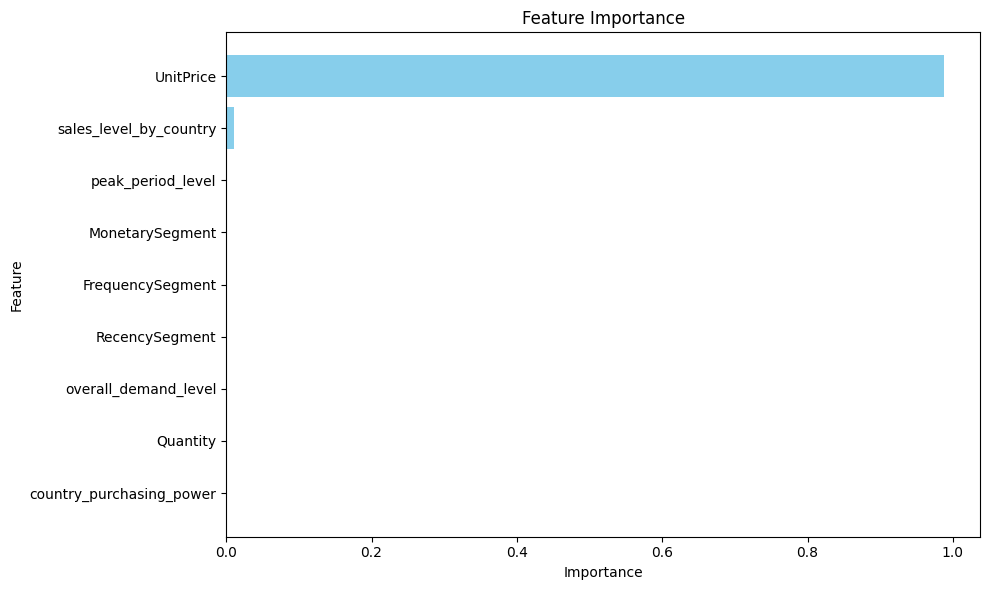

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')  # 'coerce' converts invalid dates to NaT

# **Check for invalid dates**
invalid_dates = df[pd.isna(df['InvoiceDate'])]  # Find rows where InvoiceDate is NaT (invalid)

# Display the result
print("\nInvalid dates in 'InvoiceDate' column:")
print(invalid_dates)


Invalid dates in 'InvoiceDate' column:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, hour, weekday, month, week, total_sales, peak_period_level, overall_demand_level, RecencySegment, FrequencySegment, MonetarySegment, country_purchasing_power, sales_level_by_country, adjusted_unit_price]
Index: []

[0 rows x 21 columns]


In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'hour', 'weekday', 'month',
       'week', 'total_sales', 'peak_period_level', 'overall_demand_level',
       'RecencySegment', 'FrequencySegment', 'MonetarySegment',
       'country_purchasing_power', 'sales_level_by_country',
       'adjusted_unit_price'],
      dtype='object')

In [ ]:
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

Training MSE: 0.10537893921878026
Test MSE: 0.0002141472429855384
Training R^2: 0.9138367515554843
Test R^2: 0.9980163288452965


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -scores.mean()
print(f"Mean CV MSE: {mean_cv_mse}")

Mean CV MSE: 0.7210354950273691


In [ ]:
import joblib

joblib.dump(model, 'random_forest_model.pkl')

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import pymongo
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# MongoDB Connection URI
MONGO_DB_URL = os.getenv("MONGO_URI")

# Database and Collection Names
DATABASE_NAME = "DynamicPricing"  # Change to your database name
COLLECTION_NAME = "MLData"  # Change to your collection name

# Connect to MongoDB
mongo_client = pymongo.MongoClient(MONGO_DB_URL)

# Select Database and Collection
collection = mongo_client[DATABASE_NAME][COLLECTION_NAME]
print(collection)
# Fetch Data from MongoDB (Limit to first 1000 documents)
data = list(collection.find().limit(1000))
print(data)

# Convert to Pandas DataFrame
df = pd.DataFrame(data)

# Drop `_id` column if it exists
if "_id" in df.columns:
    df.drop(columns=["_id"], inplace=True)

# Display first few rows
print(df.head())


Collection(Database(MongoClient(host=['ac-4wygsq7-shard-00-02.zg5uxhv.mongodb.net:27017', 'ac-4wygsq7-shard-00-01.zg5uxhv.mongodb.net:27017', 'ac-4wygsq7-shard-00-00.zg5uxhv.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', appname='Cluster0', authsource='admin', replicaset='atlas-b6u0p2-shard-0', tls=True), 'DynamicPricing'), 'MLData')
[]
Empty DataFrame
Columns: []
Index: []
